In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [265]:
def prepare_data (location: str) -> pd.DataFrame:
    """Return pandas dataframe with proper labeled columns and adjusted
    values.

    Args:
        location (str): The location directory in string form.

    Returns:
        pd.DataFrame: data file -> pandas dataframe
    """
    cols = ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']
    df = pd.read_csv(location, names=cols, sep=r'\s+')
    df['pos_i'] = df['pos_i'] // 1000000
    df['pos_j'] = df['pos_j'] // 1000000
    return df

In [266]:
def find_chr_length (data: pd.DataFrame) -> dict[str: tuple]:
    """Return a dictionary containing each unique chromosome mapped to their lengths
    as a tuple (min_length, max_length).
    
    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        dict: chromosome -> length (min, max)
    """
    chr_bounds = {}
    chromosomes = sorted(set(data['chr_i']).union(data['chr_j']))
    for chr_ in chromosomes:
            max_i = data.loc[data['chr_i'] == chr_, 'pos_i'].max()
            max_j = data.loc[data['chr_j'] == chr_, 'pos_j'].max()
            min_i = data.loc[data['chr_i'] == chr_, 'pos_i'].min()
            min_j = data.loc[data['chr_j'] == chr_, 'pos_j'].min()
            chr_bounds[chr_] = (min(min_i, min_j), max(max_i, max_j))
    return chr_bounds

In [267]:
def build_chr_block_matrix(data: pd.DataFrame) -> pd.DataFrame:
    """Return a DataFrame where rows and columns are chromosomes and
    each cell contains a symmetric contact matrix (DataFrame) between those chromosomes.

    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        pd.DataFrame: block DataFrame of contact matrices
    """
    # compute length of chromosome
    chr_bounds = find_chr_length(data)
    chromosomes = sorted(set(data['chr_i']).union(data['chr_j']))

    # initialize the block matrix as pandas dataframe
    chr_block_df = pd.DataFrame(index=chromosomes, columns=chromosomes, dtype=object)

    # fill each block/cell with sub contact matrices
    for chr_i in chromosomes:
        for chr_j in chromosomes:
            # set lengths for chromosome contact matrix
            min_i, max_i = chr_bounds[chr_i]
            min_j, max_j = chr_bounds[chr_j]
            row_bins = list(range(min_i, max_i + 1))
            col_bins = list(range(min_j, max_j + 1))

            # initialize zero matrix
            mat = pd.DataFrame(0, index=row_bins, columns=col_bins)

            # find subset of actual contact data for this chr pair
            subdf = data[(data['chr_i'] == chr_i) & (data['chr_j'] == chr_j)]

            # _ is just to run this loop and row represents the rows of data where contact occurs
            for _, row in subdf.iterrows():
                i, j = row['pos_i'], row['pos_j']
                mat.at[i, j] = row['contacts']
                # add symmetric entry if same chromosome
                if chr_i == chr_j:
                    mat.at[j, i] = row['contacts']
                    
            # set the contact matrix into the block matrix
            chr_block_df.at[chr_i, chr_j] = mat

    return chr_block_df

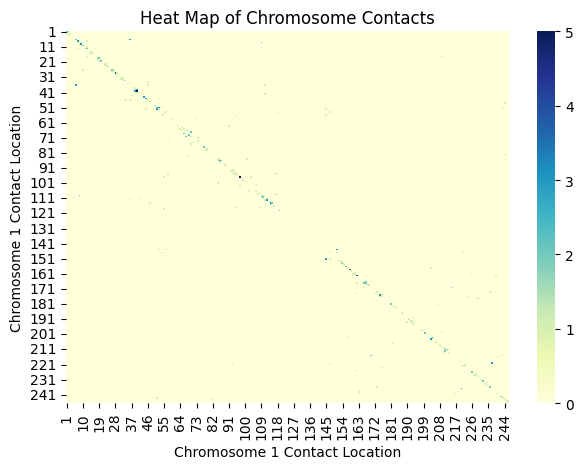

In [271]:
df = prepare_data('/Users/salah/Documents/chromosome-prediction/data/ml3_AAGCGACC-ACCTCTTG.txt')
matrix = build_chr_block_matrix(df)

sns.heatmap(matrix.at['chr1', 'chr1'], cmap='YlGnBu')
plt.title("Heat Map of Chromosome Contacts")
plt.xlabel("Chromosome 1 Contact Location")
plt.ylabel("Chromosome 1 Contact Location")
plt.tight_layout()
plt.show()

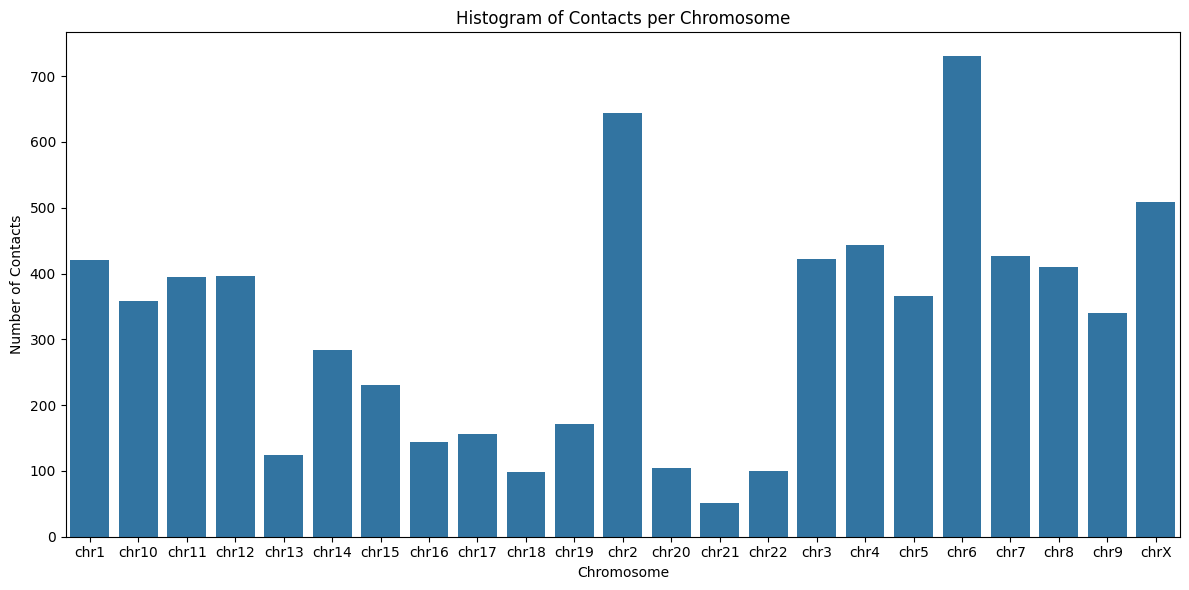

In [272]:
def sum_contacts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Count total number of contacts per chromosome from both chr_i and chr_j.
    
    Args:
        df (pd.DataFrame): DataFrame with columns ['chr_i', 'chr_j']

    Returns:
        pd.Dataframe: chromosome -> number of contacts
    """
    counts_i = df['chr_i'].value_counts()
    counts_j = df['chr_j'].value_counts()
    
    total_counts = counts_i.add(counts_j, fill_value=0).astype(int)
    total_df = total_counts.reset_index()
    total_df.columns = ['chromosome', 'total_contacts']

    return total_df.sort_values(by='chromosome')

contact_count = sum_contacts(df)
plt.figure(figsize=(12, 6))
sns.barplot(x='chromosome', y='total_contacts', data=contact_count)
plt.title("Histogram of Contacts per Chromosome")
plt.xlabel("Chromosome")
plt.ylabel("Number of Contacts")
plt.tight_layout()
plt.show()

In [ ]:
def cell_summary_stats(data: pd.DataFrame) -> dict:
    """
    Extract basic contact-level features from a single-cell Hi-C contact dataframe.

    Args:
        df (pd.DataFrame): contact data with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        dict: feature_name -> value
    """
    total_contacts = data['contacts'].sum()
    mean_contact = data['contacts'].mean()
    var_contact = data['contacts'].var()
    std_contact = data['contacts'].std()
    max_contact = data['contacts'].max()

    # Intra- vs inter-chromosomal contacts
    intra = data[data['chr_i'] == data['chr_j']]['contacts'].sum()
    inter = data[data['chr_i'] != data['chr_j']]['contacts'].sum()

    features = {
        'total_contacts': float(total_contacts),
        'mean_contact': float(mean_contact),
        ''
        'std_contact': float(std_contact),
        'max_contact': float(max_contact),
    }
    return features

In [ ]:
def chr_summary_stats(data: pd.DataFrame) -> dict:
    """
    Extract basic contact-level features from a single-cell Hi-C contact dataframe.

    Args:
        df (pd.DataFrame): contact data with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        dict: feature_name -> value
    """
    

{'total_contacts': 5834.0, 'mean_contact': 1.5935536738596012, 'std_contact': 1.051047859483259, 'max_contact': 9.0, 'intra_contacts': 5834.0, 'inter_contacts': 0.0}


In [ ]:
def get_diagonal_contact(matrix: pd.DataFrame) -> dict[str, pd.DataFrame]:
    """
    Build intra-chromosomal contact matrices for a single cell.

    Returns:
        dict: chromosome -> contact matrix (DataFrame with pos_i x pos_j)
    """
    chr_diagonal = {}
    
    for chr in matrix.index:
        chr_diagonal[chr] = matrix.at[chr, chr]
        
    avg_diagonal = {}
    
    for chr in chr_diagonal:
        diagonal = np.diag(chr_diagonal[chr])
        avg_diagonal[chr] = (float(diagonal.mean()), float(diagonal.var()))
    return avg_diagonal

{'chr1': (0.6747967479674797, 0.9348932513715381), 'chr10': (1.2592592592592593, 1.9994513031550067), 'chr11': (1.5925925925925926, 2.582167352537723), 'chr12': (1.6492537313432836, 3.0336934729338387), 'chr13': (0.5684210526315789, 0.6874238227146812), 'chr14': (1.7272727272727273, 2.06198347107438), 'chr15': (1.3333333333333333, 1.62962962962963), 'chr16': (0.9777777777777777, 1.7106172839506173), 'chr17': (0.8902439024390244, 1.0977096966091615), 'chr18': (0.5128205128205128, 0.608809993425378), 'chr19': (2.152542372881356, 3.8241884515943685), 'chr2': (1.1522633744855968, 1.4212603092347031), 'chr20': (0.8852459016393442, 1.1835528083848428), 'chr21': (0.5882352941176471, 0.5951557093425606), 'chr22': (1.7878787878787878, 2.2277318640955), 'chr3': (0.8939393939393939, 1.1756198347107436), 'chr4': (0.93717277486911, 1.3154244675310434), 'chr5': (0.8342541436464088, 1.2874454381734375), 'chr6': (2.216374269005848, 3.7718956260045826), 'chr7': (1.25, 1.725), 'chr8': (0.909722222222222

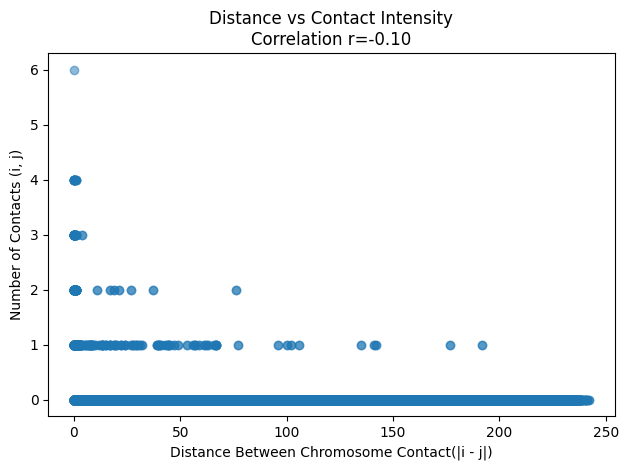

In [281]:
def calculate_dist_contact(matrix: pd.DataFrame) -> dict:
    """
    Compute distance-from-diagonal vs contact intensity for a symmetric matrix.

    Args:
        matrix (pd.DataFrame): contact matrix (e.g., chr3 vs chr3)

    Returns:
        dict: {
            'distances': list of |i - j| (distance between contact points),
            'contacts': list of contacts,
            'correlation': Pearson correlation (distance vs contact)
        }
    """
    distances = []
    contacts = []

    idx_to_pos = list(matrix.index)
    col_to_pos = list(matrix.columns)

    for i, row_pos in enumerate(idx_to_pos):
        for j, col_pos in enumerate(col_to_pos):
            contact = matrix.iat[i, j] # The contact on the i, j position
            dist = abs(i - j) # distance from position i to j
            distances.append(dist)
            contacts.append(contact)

    # Correlation analysis
    corr, _ = pearsonr(distances, contacts) # calculate linear correlation

    return {'distances': distances, 'contacts': contacts, 
            'correlation': corr}

contact_matrix = matrix.at['chr2', 'chr2'] 
dist_contact = calculate_dist_contact(contact_matrix)

plt.scatter(dist_contact['distances'], dist_contact['contacts'], alpha=0.5)
plt.title(f"Distance vs Contact Intensity\nCorrelation r={dist_contact['correlation']:.2f}")
plt.xlabel("Distance Between Chromosome Contact(|i - j|)")
plt.ylabel("Number of Contacts (i, j)")
plt.tight_layout()
plt.show()